# $\color{red}{\text{Prototypes}}$
>## $\color{cyan}{\text{What are prototypes?}}$

>>A prototype is a data instance that is representative of all the data.

>## $\color{cyan}{\text{Why are they useful?}}$

>>Using prototype methods to reduce the size of training datasets can drastically reduce the computational cost of classification with instance-based learning algorithms like the k-Nearest Neighbour classifier

# $\color{red}{\text{CSE 251A Project 1}}$
>## $\color{cyan}{\text{Goal}}$

>>To explore different prototyping methods and compare their performance in a 1-NN classifier

> The dataset that will be used will be the MNIST dataset.

## $\color{cyan}{\text{Prototyping methods explored}}$
* Condensed Nearest Neighbor
* Wilson's Editting
* K Means Prototype

In [ ]:
#install necessary packages
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist #MNIST handwritten digits dataset
from keras.utils import np_utils #NumPy related tools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import random
import time
import seaborn as sns
import pandas as pd
from google.colab import files

In [ ]:
#implementation of the condensed nearest neighbors algorithm (5 min for 10000)
def condensed_nn (X_train,y_train,M):
  #prototype holds the indexes of the training set that will be used as prototypes
  prototype = []
  prototype.append(0)
  rand = random.sample(range(0,X_train.shape[0]),X_train.shape[0])
  additions = True
  while additions == True:
    additions = False
    for i in range(X_train.shape[0]):
      if len(prototype) >= M:
        return prototype
      nn_model = KNeighborsClassifier(n_neighbors = 1)
      nn_model.fit(X_train[prototype],y_train[prototype])
      if nn_model.predict(X_train[i].reshape(1,-1)) != y_train[rand[i]]:
        prototype.append(rand[i])
        additions = True
  return prototype

In [ ]:
#implementation of Wilson's Edited Nearest Neighbor (5 minutes for 1000, 25 min for 5000)
def wilson_nn (X_train, y_train, M):
  #prototypes holds the indexes of the training set that will be used as prototypes
  prototype = []
  rand = random.sample(range(0,X_train.shape[0]),X_train.shape[0])
  for i in range(X_train.shape[0]):
    if len(prototype) >= M:
      return prototype
    top = rand.pop(0)
    nn_model = KNeighborsClassifier(n_neighbors = 1)
    nn_model.fit(X_train[rand],y_train[rand])
    if nn_model.predict(X_train[top].reshape(1,-1)) == y_train[top]:
      prototype.append(top)
    rand.append(top)
  return prototype

In [ ]:
#implementation of K-Means Nearest Neighbor (1 min for 100, 5 min for 1000)
def kmeans_nn (X_train, y_train, M):
  #prototypes holds the indexes of the training set that will be used as prototypes
  prototype = []
  classes = len(np.unique(y_train))
  num_clusters = int(M/classes)
  x_index = [ [] for _ in range(classes) ]
  for i in range(len(y_train)):
    x_index[y_train[i]].append(i)
  iter = 0
  for x in x_index:
    cc = KMeans(n_clusters = num_clusters).fit(X_train[x]).cluster_centers_
    pt, _ = pairwise_distances_argmin_min(cc,X_train)
    prototype.append(pt)
  prototype = np.concatenate(prototype).ravel()
  return prototype

In [ ]:
#implementation of uniform-random select
def rand_uni_nn(X_train, y_train, M):
  prototype = random.sample(range(0,X_train.shape[0]),M)
  return prototype

In [ ]:
#experiment function to get all values
#ss_1, ss_2, ss_3 cleaned up for a consistent runthrough
#this would take probably a whole day to run
def experiment():
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
  X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

  X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
  X_test = X_test.astype('float32')

  X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
  X_test /= 255
  runs = 5
  ss_1 = np.array([1000,1500, 2000, 5000, 10000], dtype = int) #for random and cnn
  ss_2 = np.array([500, 1000, 2000, 5000, 10000], dtype = int) #for wilsons 
  ss_3 = np.array([100, 500,  1000, 2000, 5000], dtype = int) #for kmeans
  types = np.array(['rand','cnn'], dtype = object)
  err = np.zeros((len(types)*len(ss_1),runs))
  times = np.zeros((len(types)*len(ss_1),runs))
  for run in range(runs):
    for idx,ss in enumerate(ss_1):
      for type in types:
        nn_model = KNeighborsClassifier(n_neighbors = 1)
        start = time.time()
        if type == 'rand':
          prototype = rand_uni_nn(X_train, y_train, ss_1[idx])
          x = idx
        elif type == 'cnn':
          prototype = condensed_nn(X_train, y_train, ss_1[idx])
          x = idx + len(ss_1)
        elif type == 'wilson':
          prototype = wilson_nn(X_train, y_train, ss_2[idx])
          x =  idx + 2 * len(ss_1)
        else:
          prototype = kmeans_nn(X_train, y_train, ss_3[idx])
          x =  idx + 3 * len(ss_1)
        end = time.time()
        times[x,run] = end - start
        nn_model.fit(X_train[prototype], y_train[prototype])
        err[x,run] = 1 - nn_model.score(X_test, y_test)
  return times
  return err

In [ ]:
uploaded = files.upload()
res = pd.read_excel(r'res.xlsx',sheet_name='Export')
print(res)

Saving res.xlsx to res (4).xlsx
      Method Metric  Sample Size     Method + SS      Average         SD
0     Random   Time         1000     Random,1000     0.001104   0.000192
1     Random   Time         1500     Random,1500     0.001677   0.000294
2     Random   Time         2000     Random,2000     0.001978   0.000057
3     Random   Time         5000     Random,5000     0.004823   0.000038
4     Random   Time        10000    Random,10000     0.011431   0.000554
5        CNN   Time         1000        CNN,1000     4.554151   0.303407
6        CNN   Time         1500        CNN,1500    10.808848   0.312091
7        CNN   Time         2000        CNN,2000    18.029421   0.345593
8        CNN   Time         5000        CNN,5000    91.589067  13.617043
9        CNN   Time        10000       CNN,10000   336.887005  32.772056
10  Wilson's   Time          500    Wilson's,500   164.108064  13.322816
11  Wilson's   Time         1000   Wilson's,1000   331.579645  28.029940
12  Wilson's   Time

Text(0.5, 1.0, 'Average Runtime of Prototype Selection Algorithms')

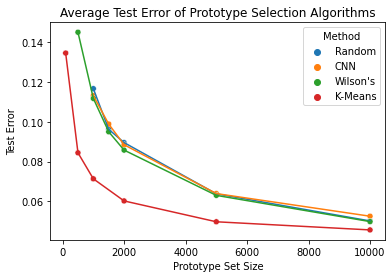

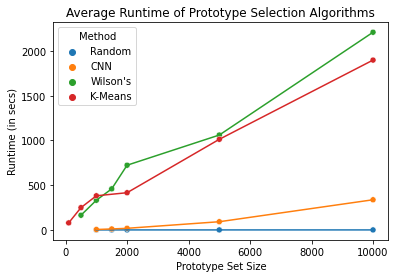

In [ ]:
err = res.loc[res['Metric'] == 'Error']
times =  res.loc[res['Metric'] == 'Time']
ss_err = []
avg_err = []
ss_times = []
avg_times = []
 
plt.figure()
lpe = sns.lineplot(x = err['Sample Size'], y = err['Average'], hue = err['Method'], legend = False)
spe = sns.scatterplot(x = err['Sample Size'], y = err['Average'], hue = err['Method'])
plt.xlabel("Prototype Set Size")
plt.ylabel("Test Error")
plt.title("Average Test Error of Prototype Selection Algorithms")
plt.figure()
sns.lineplot(x = times['Sample Size'], y = times['Average'], hue = times['Method'], legend = False)
sns.scatterplot(x = times['Sample Size'], y = times['Average'], hue = times['Method'])
plt.xlabel("Prototype Set Size")
plt.ylabel("Runtime (in secs)")
plt.title("Average Runtime of Prototype Selection Algorithms")